## Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [1]:
import matplotlib as mpl  # for colour maps
import matplotlib.pyplot as plt  # because Figures >> Text
import numpy as np  # ...of course we need numpy
import pandas as pd  # for seaborn, I guess
import palettable as pt  # nicer color pallettes
import pickle  # output export/import
import seaborn as sns  # for pretty plots

In [2]:
cmap = pt.scientific.sequential.Tokyo_4_r.get_mpl_colormap()
cmap2 = mpl.colormaps["magma"]

#### Figure 1

What:
Changes in computation times.

Varying parameters:
- $t_{max} = 1eX, X\in\{2,3,4,5,6,7^?\}$
- $N_{agents} = 1eX, X\in\{1,2,3,4,5\}$

Bonus points:
- plot expected number of events $N_{events} \approx (r+h)\cdot N_{nodes}\cdot t_{max}$ for comparison
    - deviations would be due to non-event-related stuffs, e.g. sampling (which will take a toll at some $N_{nodes}$)


In [3]:
# give to-be-analysed data
## I know this is rudimental, but hey, it works for me, for now.

data_dir = "../tests/data/2024-02--Run1/"

# 0.) 2D plot data
n_arr = [int(10**N) for N in np.arange(1, 4.5, 0.5)]
t_arr = [
    int(10**t) for t in np.arange(1, 5, 1)
]  # !!! arbitrary rates --> to be divided by 100

res_NT = []
res_T = []
res_N = []
for N in n_arr:
    for t in t_arr:
        filename = "out--N_nodes-" + str(N) + "--t_max-" + str(t) + ".pkl"
        res_NT.append(filename)
        if N == 100:
            res_T.append(filename)
        if t == 10000:
            res_N.append(filename)

# 1.) t_max, t_exec (N=100)
for t in [int(10**t) for t in [5, 5.5, 6]]:
    res_T.append("out--t_max-" + str(t) + ".pkl")

# 2.) N_nodes, t_exec (t_max = 10000)
for N in [int(10**N) for N in [4.5]]:
    res_N.append("out--N_nodes-" + str(N) + ".pkl")

In [4]:
# Import pickle data from paramter scan runs:

# Extract 't_exec' for {N_nodes, t_max} adaptions for 3d plot
exec_times_NT = []

for file in res_NT:
    with open(data_dir + file, "rb") as export:
        output = pickle.load(export)
        exec_times_NT.append(output["t_exec"])
exec_times_NT = np.array(exec_times_NT).reshape(len(t_arr), len(n_arr))

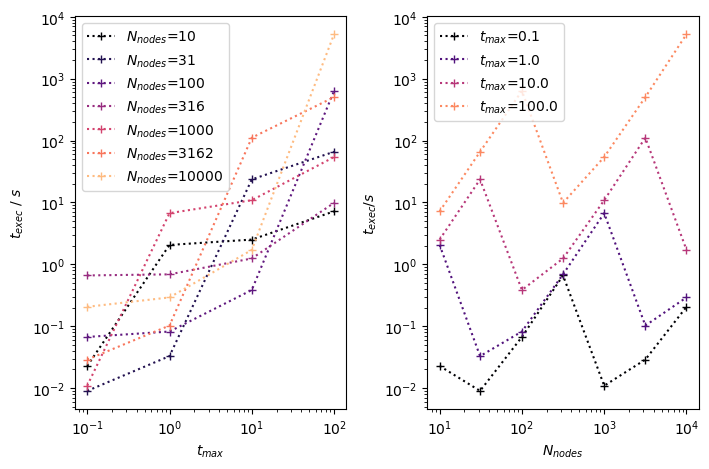

In [5]:
fig1 = plt.figure(figsize=plt.figaspect(2 / 3))

# Plot 1_1 -- (x,y) = (t_max,t_exec); loop over N_nodes
x_T = np.array(t_arr) / 100  # because t_arr used arbitrary rates
y_T = [exec_times_NT[:, i] for i in range(len(n_arr))]

ax1_1 = fig1.add_subplot(1, 2, 1)
ax1_1.set_prop_cycle("color", cmap2(np.linspace(0, 1 - 1 / len(y_T), len(y_T))))
for y in y_T:
    ax1_1.plot(x_T, y, ls=":", marker="+")

ax1_1.legend(["$N_{nodes}$=" + str(N) for N in n_arr])
ax1_1.set_xlabel("$t_{max}$")
ax1_1.set_xscale("log")
ax1_1.set_ylabel("$t_{exec}\ /\ s$")
ax1_1.set_yscale("log")


# Plot 1_2 -- (x,y) = (N_nodes,t_exec); loop over t_max
x_N = np.array(n_arr)
y_N = [exec_times_NT[i, :] for i in range(len(t_arr))]

ax1_2 = fig1.add_subplot(1, 2, 2)
ax1_2.set_prop_cycle("color", cmap2(np.linspace(0, 1 - 1 / len(y_N), len(y_N))))
for y in y_N:
    ax1_2.plot(x_N, y, ls=":", marker="+")

ax1_2.legend(
    ["$t_{max}$=" + str(t / 100) for t in t_arr]
)  # because t_arr used arbitrary rates
ax1_2.set_xlabel("$N_{nodes}$")
ax1_2.set_xscale("log")
ax1_2.set_ylabel("$t_{exec}/s$")
ax1_2.set_yscale("log")

fig1.tight_layout()
plt.show()

## Figure 2

Distance (KLD, lin., quad.), given
1. $(r,h)\in\{ (1,1),(5,5),(0.1,5),(5,0.1)\}$
2. $N_{nodes}\in 1e(1,1.5,2,2.5,3,3.5,4)$

In [6]:
# give to-be-analysed data
## I know this is rudimental, but hey, it works for me, for now.

data_dir = "../tests/data/2024-02--Run1/"

# 1.) (r,h) data
rates = [(1, 1), (5, 5), (0.1, 5), (5, 0.1)]
N_log = np.arange(1, 4.5, 0.5)
N_arr = [int(10**N) for N in N_log]

res_rates = []
for N in n_arr:
    for i in rates:
        if i[0] == 1 and i[1] == 1:
            filename = "out--N_nodes-" + str(N) + "--t_max-10000.pkl"
        else:
            filename = (
                "out--N_nodes-"
                + str(N)
                + "--r-"
                + str(i[0])
                + "--h-"
                + str(i[1])
                + ".pkl"
            )
        res_rates.append(filename)

In [7]:
res_rates = np.array(res_rates).reshape(7, 4)
print(res_rates[:, 0])
print(res_rates[2, :])

['out--N_nodes-10--t_max-10000.pkl' 'out--N_nodes-31--t_max-10000.pkl'
 'out--N_nodes-100--t_max-10000.pkl' 'out--N_nodes-316--t_max-10000.pkl'
 'out--N_nodes-1000--t_max-10000.pkl' 'out--N_nodes-3162--t_max-10000.pkl'
 'out--N_nodes-10000--t_max-10000.pkl']
['out--N_nodes-100--t_max-10000.pkl' 'out--N_nodes-100--r-5--h-5.pkl'
 'out--N_nodes-100--r-0.1--h-5.pkl' 'out--N_nodes-100--r-5--h-0.1.pkl']


In [8]:
# Import pickle data from paramter scan runs:

# Extract distances for different N_nodes t_max=10000, r=1, h=1)
kld_N = []
lin_N = []
quad_N = []

for file in res_rates[:, 0]:
    with open(data_dir + file, "rb") as export:
        output = pickle.load(export)
        kld_N.append(np.array(output["kl_divs"])[:, 1, :])
        lin_N.append(np.array(output["p_distances"])[:, 0, 1, :])
        quad_N.append(np.array(output["p_distances"])[:, 1, 1, :])

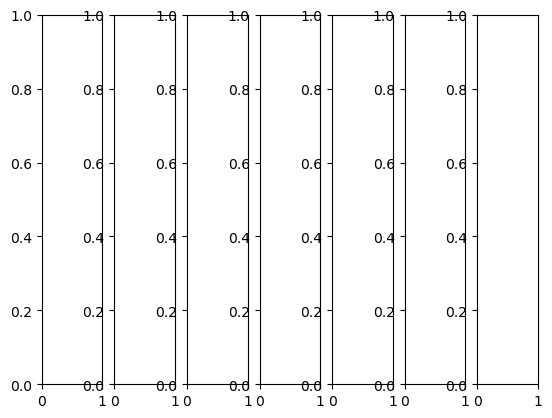

In [10]:
t_sample = 250

fig_dist_N = plt.figure()
ax_dist_N = []
runs = len(kld_N)

for i in range(runs):
    kld = np.array(kld_N[i])
    ax_tmp = fig_dist_N.add_subplot(1, runs, i + 1)

    x = t_sample * np.arange(0, kld.shape[0])
    # for y in len(kld.shape
    # plt.plot(250*np.arange(0,kld_N.shape[0]), kld_N[:,k])

In [14]:
len(kld_N)

7